In [1]:
%matplotlib notebook

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import statistics
from scipy.spatial import KDTree
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import os
import rasterio
from osgeo import gdal, gdal_array, osr
from pyproj.transformer import Transformer, CRS
from datetime import datetime, timedelta

In [2]:
''' Corners of the box of interest '''
location = 0
centers  = [[-153.65, 66.70], # Alatna (2, 3572)
            [-155.69, 66.01], # Huslia (2, 3612)
            [-157.01, 66.96], # (2, 3548)
            [-157.82, 65.81], # (2, 3630)
            [-158.34, 65.23], # (2, 3674)
            [-153.05, 67.12], # (2, 3537)
            [-152.30, 67.12], # (2, 3539)
            [-150.92, 66.71], # (2, 3568)
            [-146.44, 66.96], # (2, 3550) 
            [-153.26, 64.53]] # (2, 3728)

min_lon = centers[location][0] - .65
max_lon = centers[location][0] + .65
min_lat = centers[location][1] - .25
max_lat = centers[location][1] + .25

box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

print(max(box_lon), min(box_lon), min_lon, max_lon, min_lat, max_lat)

-153.0 -154.3 -154.3 -153.0 66.45 66.95


## Get paths of the fire .tif files

In [3]:
day_fire = 1
fire_paths = ['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Huslia/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/MODIS_Fire',
              '/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/MODIS_Fire']

In [4]:
def GetFilePaths(folder_path):
    paths = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.tif'):
            paths.append(os.path.join(folder_path, file))
            
    return paths

In [5]:
fire_files = GetFilePaths(fire_paths[location])

print(fire_files)

['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/MODIS_Fire/Modis_MaxFRP_Alatna_195.tif', '/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/MODIS_Fire/Modis_MaxFRP_Alatna_196.tif', '/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/MODIS_Fire/Modis_MaxFRP_Alatna_197.tif']


## Temperature file paths

In [6]:
tmax_files = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/Temp/tmax_Alatna_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia/Temp/tmax_Huslia_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Temp/tmax_Loc1_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Temp/tmax_Loc2_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Temp/tmax_Loc3_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Temp/tmax_Loc4_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Temp/tmax_Loc5_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Temp/tmax_Loc6_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Temp/tmax_Loc7_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Temp/tmax_Loc8_2016_1_1-2016_12_31_krig_grid.nc"]

<IPython.core.display.Javascript object>


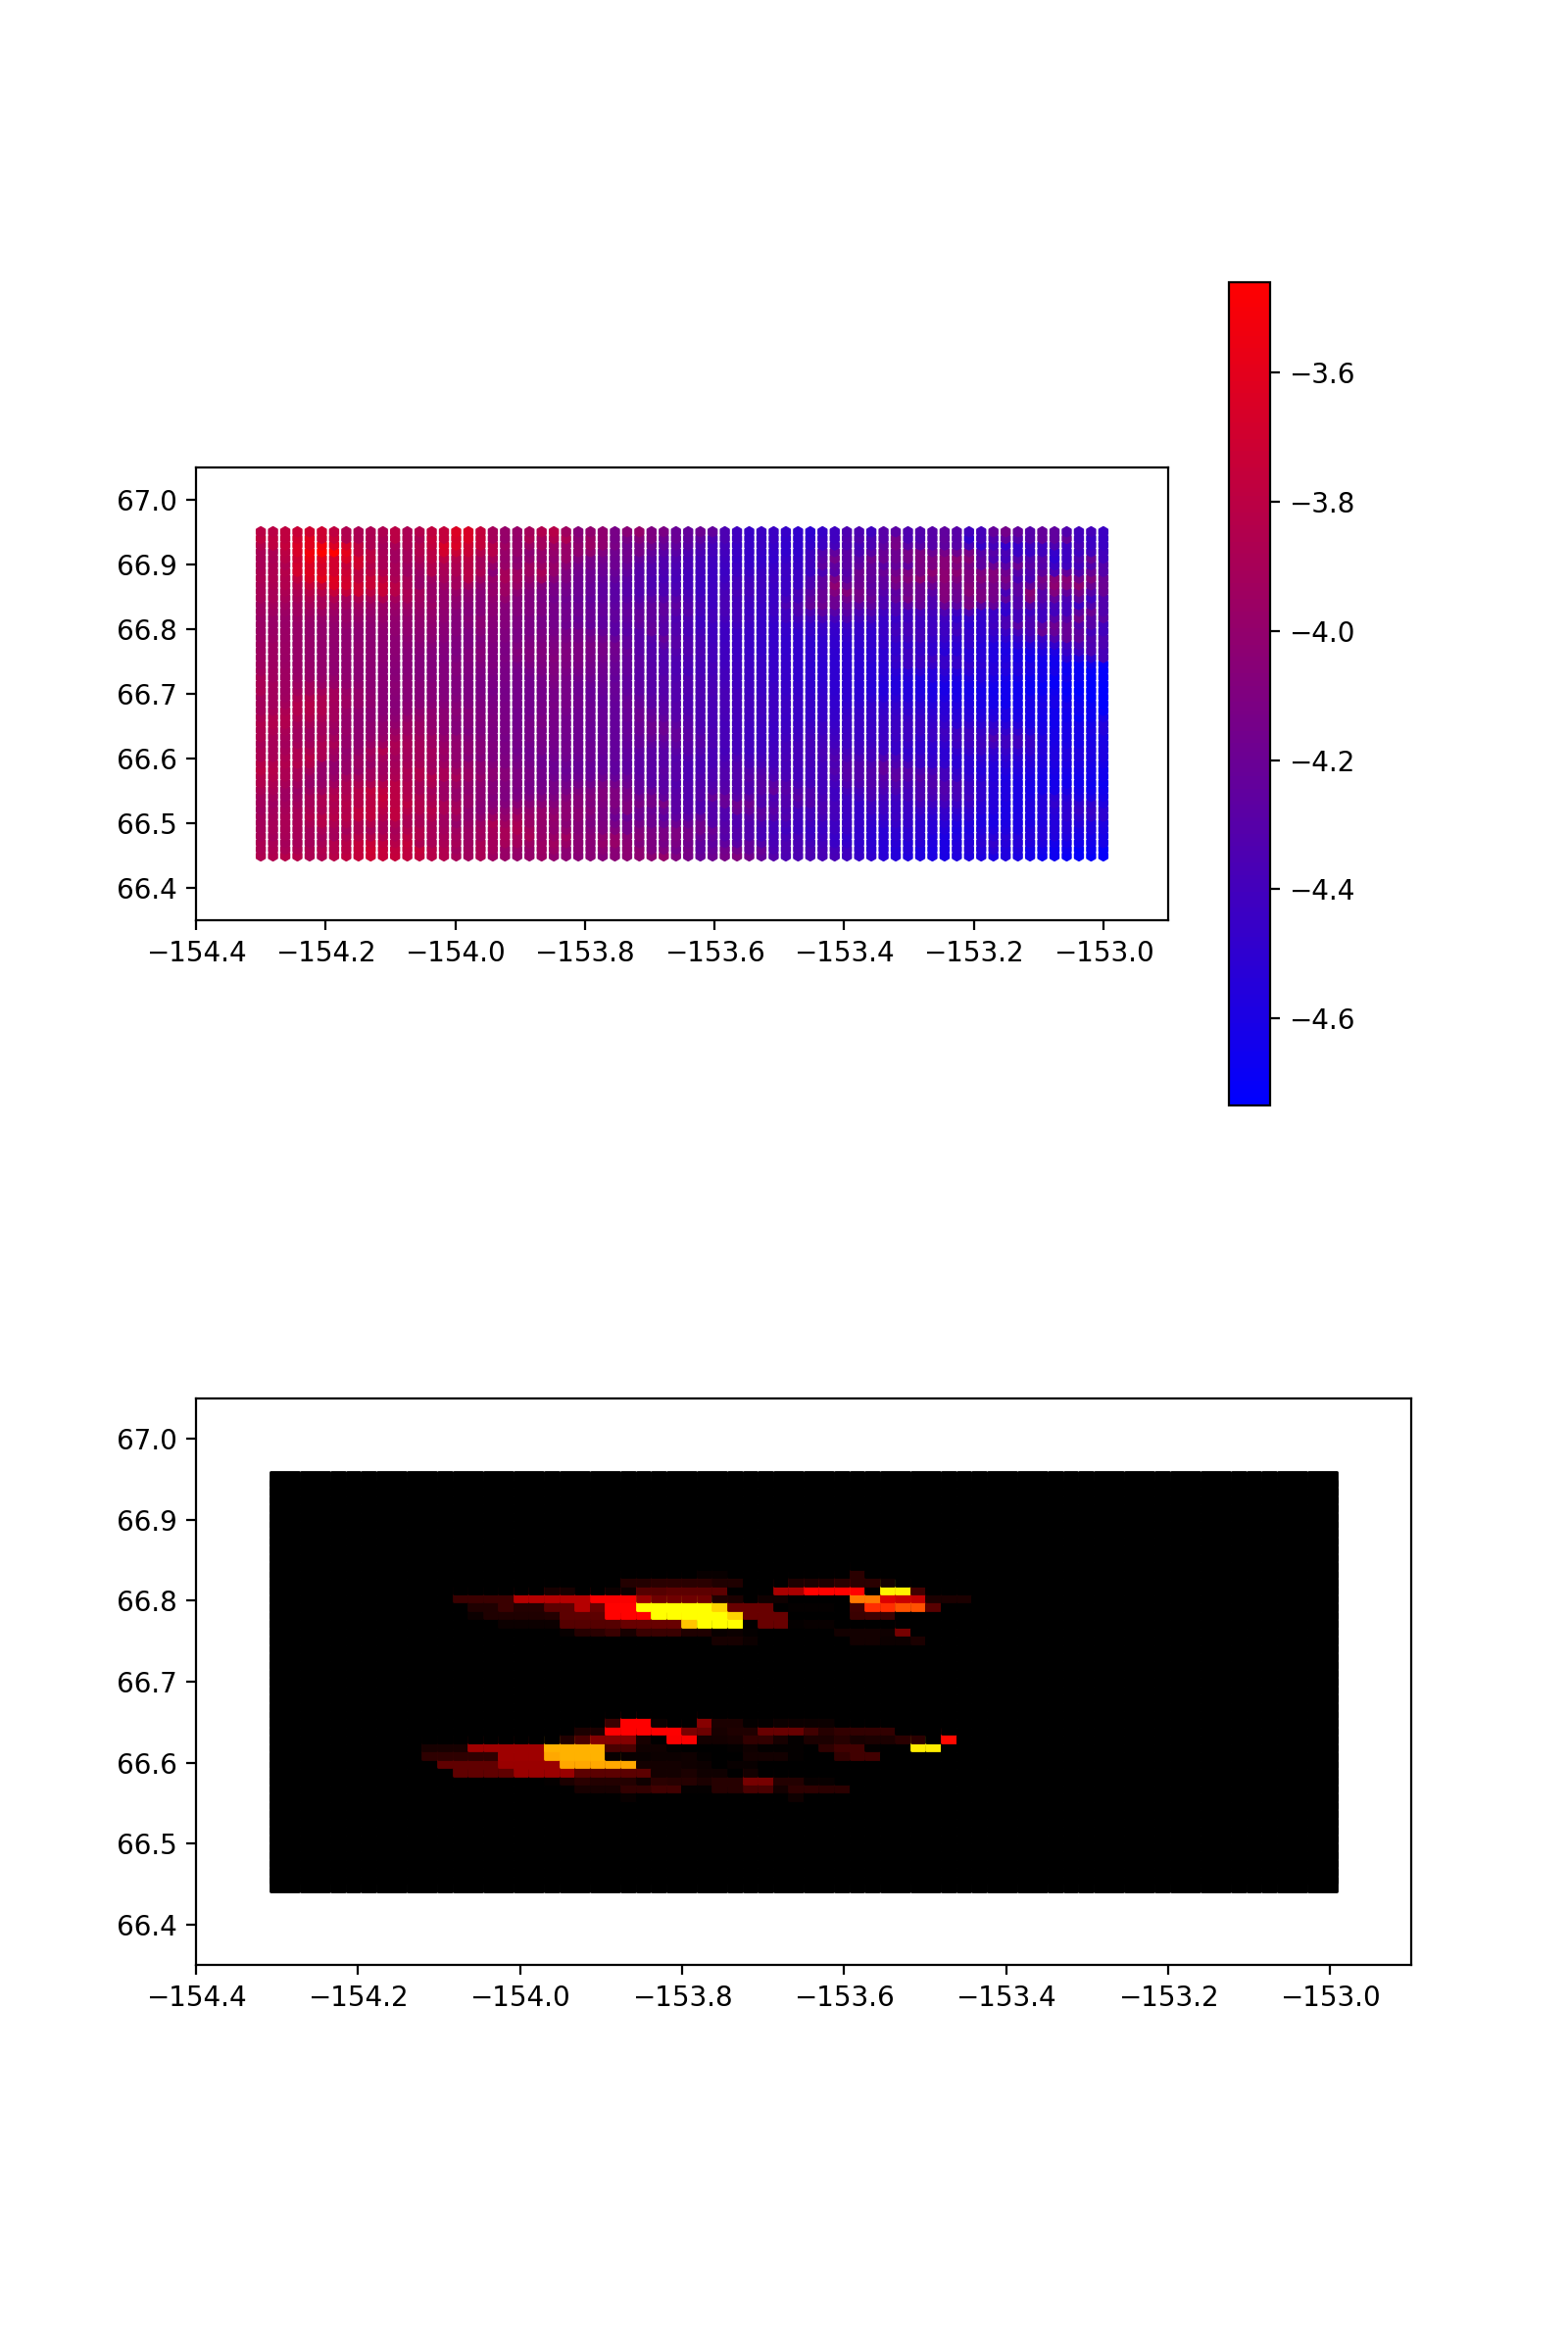

(66.35000000000001, 67.05)

In [7]:
fig, ax = plt.subplots(2, figsize=(8, 12))

ax[0].set_xlim(min_lon - .1, max_lon + .1)
ax[1].set_xlim(min_lon - .1, max_lon + .1)
ax[0].set_ylim(min_lat - .1, max_lat + .1)
ax[1].set_ylim(min_lat - .1, max_lat + .1)

## Get Fire data

In [8]:
raster = rasterio.open(fire_files[day_fire])
band =  raster.read(1)

raster_gdal = gdal.Open(fire_files[day_fire])

prj = raster_gdal.GetProjection()

print(prj)
srs = osr.SpatialReference(wkt=prj)

PROJCS["NAD83 / Alaska Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3338"]]


In [9]:
print(raster.width, raster.height, raster.bounds, raster.transform)

1939 1863 BoundingBox(left=-13425.0, bottom=1832505.0, right=44745.0, top=1888395.0) | 30.00, 0.00,-13425.00|
| 0.00,-30.00, 1888395.00|
| 0.00, 0.00, 1.00|


## Get transforms

In [10]:
in_sr = osr.SpatialReference()
in_sr.ImportFromEPSG(3338) # What I used in Google Earth Engine

# Define the output coordinate system (latitude-longitude in this case)
out_sr = osr.SpatialReference()
out_sr.ImportFromEPSG(4326)

# Create the transformation object
transformer = osr.CoordinateTransformation(in_sr, out_sr)
# Get the geographic transform for the image
transform = raster_gdal.GetGeoTransform() # from GDAL

print("transform =", transform)

transform = (-13425.0, 30.0, 0.0, 1888395.0, 0.0, -30.0)


## Transform pixels -> meters -> lat/lon

In [11]:
lon_fire = np.empty_like(band, float)
lat_fire = np.empty_like(band, float)

for i in range(np.shape(band)[0]):
    for j in range(np.shape(band)[1]):
        x_m = transform[0] + j * transform[1] + i * transform[2]
        y_m = transform[3] + j * transform[4] + i * transform[5]

        lat, lon, _ = transformer.TransformPoint(x_m, y_m)
        
        #print("x =", x_pix, ", y =", int(y_pix), " , x =", int(x_m), ", y =", y_m, ", lon =", lon, ", lat =", lat)
        
        lon_fire[i][j] = lon
        lat_fire[i][j] = lat

In [12]:
print(round(min(lon_fire.ravel()), 2), round(max(lon_fire.ravel()), 2), round(min(lat_fire.ravel()), 2), round(max(lat_fire.ravel()), 2))
print(min_lon, max_lon, min_lat, max_lat)
print(np.shape(lon_fire), np.shape(lat_fire), np.shape(band))

-154.31 -152.98 66.45 66.95
-154.3 -153.0 66.45 66.95
(1863, 1939) (1863, 1939) (1863, 1939)


In [13]:
''' Get points for the fire plot and box '''
points_fire = [Point(xy) for xy in zip(lon_fire.ravel(), lat_fire.ravel())]
points_gdf = gpd.GeoDataFrame(geometry=points_fire)

In [14]:
''' Corners of the box of interest '''
box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

points_box = [Point(xy) for xy in zip(box_lon, box_lat)]
points_box_gdf = gpd.GeoDataFrame(geometry=points_box)

In [15]:
fire_gdf = gpd.GeoDataFrame(geometry=points_fire).assign(data=band.ravel())

In [16]:
print(fire_gdf.head())

                      geometry  data
0  POINT (-154.30579 66.95292)     0
1  POINT (-154.30510 66.95292)     0
2  POINT (-154.30442 66.95293)     0
3  POINT (-154.30374 66.95293)     0
4  POINT (-154.30305 66.95293)     0


In [17]:
fire_norm = Normalize(vmin=min(band.ravel()), vmax=max(band.ravel()))
fire_cmap = LinearSegmentedColormap.from_list('custom', ['black', 'red', 'orange', 'yellow'], N=200) # Higher N=more smooth

## Get Tmax

In [18]:
f = nc.Dataset(tmax_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_tmax = f.variables["lat"] # Pointer to variable
lat_tmax = np.array(lat_tmax[:]) # : Extracts the numbers

lon_tmax = f.variables["lon"]
lon_tmax = np.array(lon_tmax[:])

time_tmax = f.variables["time"]
time_tmax = np.array(time_tmax[:])

tmax = f.variables["tmax"]
tmax = np.array(tmax[:])

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'tmax'])


In [19]:
print(np.shape(lat_tmax), np.shape(lon_tmax), min(lat_tmax.ravel()), max(lat_tmax.ravel()), min(lon_tmax.ravel()), max(lon_tmax.ravel()), np.shape(tmax))

''' Get points for the temp plot '''
points_tmax = [Point(xy) for xy in zip(lon_tmax.ravel(), lat_tmax.ravel())]
points_tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax)

(70, 50) (70, 50) 66.45 66.95 -154.3 -153.0 (365, 70, 50)


                                  Set the date

In [20]:
day_temp = 300

In [21]:
tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=tmax[day_temp, :].ravel())

print(tmax_gdf.head())

                      geometry   data
0  POINT (-154.30000 66.45000) -3.860
1  POINT (-154.30000 66.46021) -3.875
2  POINT (-154.30000 66.47041) -3.875
3  POINT (-154.30000 66.48061) -3.900
4  POINT (-154.30000 66.49081) -3.910


In [22]:
tmax_norm = Normalize(vmin=min(tmax[day_temp, :].ravel()), vmax=max(tmax[day_temp, :].ravel()))
tmax_cmap = LinearSegmentedColormap.from_list('custom', ['blue', 'red'], N=200)

## Plot unkriged

In [23]:
#fire_gdf.plot(ax=ax[0], column='data', cmap=fire_cmap, norm=fire_norm, markersize=.01)

#plt.draw()

In [24]:
tmax_gdf.plot(ax=ax[0], column='data', cmap=tmax_cmap, norm=tmax_norm, marker='h', markersize=10, alpha=1, legend=True)

plt.draw()

In [25]:
#points_box_gdf.plot(ax=ax[0], color='lime', edgecolor='lime', linewidth=.5, alpha=1)

#plt.draw()

In [26]:
start_datetime = datetime.strptime('2016-1-1', '%Y-%m-%d')
# calculate the date n days after the start date
end_datetime = start_datetime + timedelta(days=day_temp)
# convert the datetime object to a string
end_date = end_datetime.strftime('%Y-%m-%d')

#ax[0].set_title('Fire: ' + fire_files[day_fire][-14:-4] + " | Temp.: " + end_date)

## Save lat lon as excel files

## Perform kriging

In [27]:
''' Flatten stuff to feed into the tree '''
new_fire = np.empty((np.shape(tmax)[1], np.shape(tmax)[2]), dtype=float)

lon_fire = np.array(lon_fire.ravel())
lat_fire = np.array(lat_fire.ravel())
band = np.array(band.ravel())

print(np.shape(new_fire), np.shape(band), np.shape(band.ravel()))
print(np.array([lon_fire.ravel(), lat_fire.ravel()]).T.reshape(-1,2))

(70, 50) (3612357,) (3612357,)
[[-154.30578646   66.95292277]
 [-154.30510314   66.95292401]
 [-154.30441983   66.95292525]
 ...
 [-153.00206425   66.44734674]
 [-153.00139392   66.44734269]
 [-153.00072359   66.44733863]]


In [28]:
tree = KDTree(np.array([lon_fire, lat_fire]).T.reshape(-1,2))

In [29]:
''' Obtain the ## nearest pixels, set new value to the color of the majority '''
for i in range(np.shape(tmax)[1]):
    for j in range(np.shape(tmax)[2]):
        ''' Get closest neighbors to desired point in tmax '''
        point = np.array([lon_tmax[i][j], lat_tmax[i][j]])

        dis, idx = tree.query(point, k = 50) 
    
        lon_krig = lon_fire[idx]
        lat_krig = lat_fire[idx]
        val_krig = band[idx]
    
        print("---------------", statistics.mode(val_krig), "------------------")
        #print("i =", i, ", idx =", idx, ", val =", val_krig, ", point =", point, " lon =", lon_krig, ", lat =", lat_krig)
        new_fire[i][j] = statistics.mode(val_krig)

--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
--------------- 0 ------------------
-

## Replot kriged data to check

In [30]:
print(np.shape(points_tmax), np.shape(new_fire))

new_fire_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=new_fire.ravel())

(3500,) (70, 50)


In [31]:
new_fire_norm = Normalize(vmin=min(new_fire.ravel()), vmax=max(new_fire.ravel()))
new_fire_cmap = LinearSegmentedColormap.from_list('custom', ['black', 'red', 'orange', 'yellow'], N=200) # Higher N=more smooth

In [32]:
#fire_gdf.plot(ax=ax[1], column='data', cmap=fire_cmap, norm=fire_norm, markersize=.01)

#plt.draw()

In [33]:
new_fire_gdf.plot(ax=ax[1], column='data', cmap=new_fire_cmap, norm=new_fire_norm, marker='s', markersize=25)

plt.draw()

In [34]:
#tmax_gdf.plot(ax=ax[1], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=5, alpha=.5, legend=True)

#plt.draw()

## Save kriged data

In [35]:
df = pd.DataFrame({'lon': lon_tmax.ravel(), 'lat': lat_tmax.ravel(), 'MaxFRP': new_fire.ravel()})

In [36]:
print(fire_files[day_fire][-7:-4])
loc_names = ['Alatna', 'Huslia', 'Loc1', 'Loc2', 'Loc3', 
             'Loc4', 'Loc5', 'Loc6', 'Loc7', 'Loc8']

df.to_excel(os.path.join(fire_paths[location], 
                         'Modis_MaxFRP_'+loc_names[location]+'_'+fire_files[day_fire][-7:-4]+'_krig_grid.xlsx'))

196


In [37]:
plt.savefig('/Users/joshuamiller/Documents/SULI 2023/Figures/'+
             'Tmax_'+loc_names[location]+'_'+fire_files[day_fire][-7:-4]+'_krig_grid.pdf',
             bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


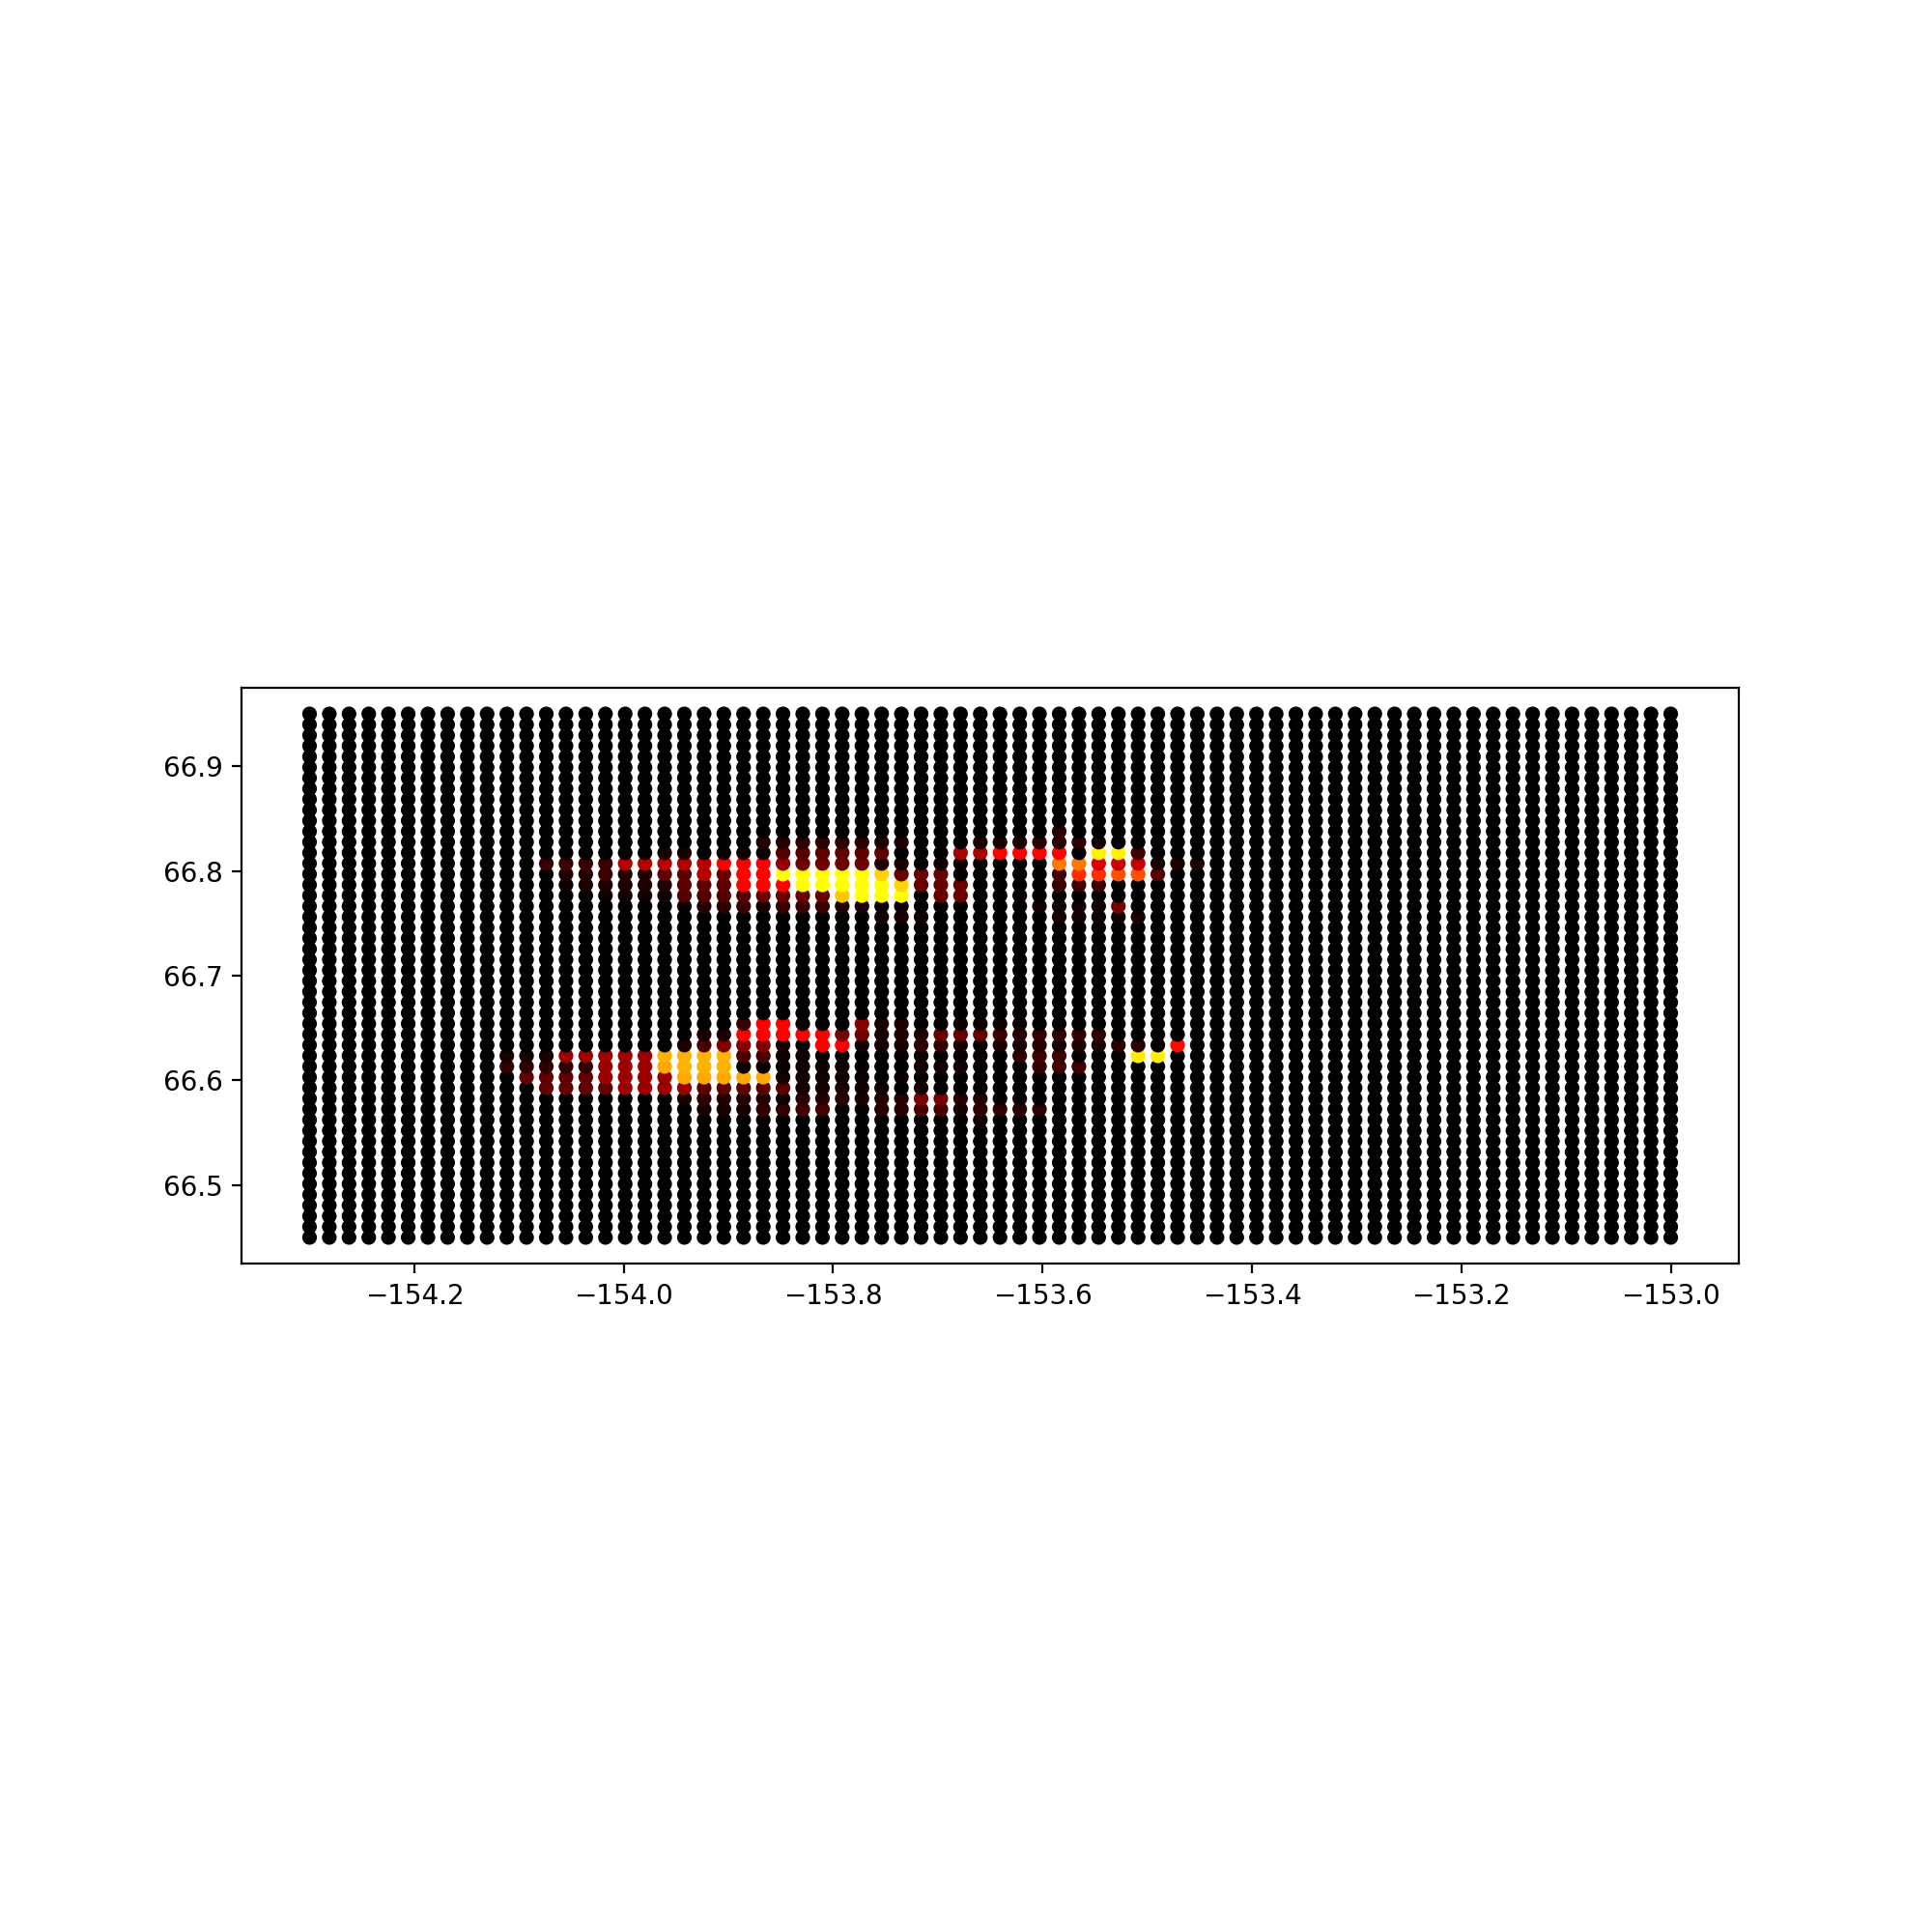

In [39]:
fig_mod, ax_mod = plt.subplots(figsize=(10, 10))

new_fire_gdf.plot(ax=ax_mod, column='data', cmap=new_fire_cmap, norm=new_fire_norm, markersize=20, alpha=1)
plt.draw()

plt.savefig('/Users/joshuamiller/Documents/SULI 2023/Figures/'+
            'maxFRP_'+loc_names[location]+'_'+fire_files[day_fire][-7:-4]+'_krig_grid.pdf',
            bbox_inches = 'tight', pad_inches = 0)